In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = os.path.abspath(".") 
if project_root not in sys.path:
    sys.path.append(project_root)
print(sys.path[-1])


/Users/dannyhuang/Developer/gflownet2/base


In [2]:
import numpy as np   
import argparse
import torch
from tqdm import tqdm

from disc_gflownet.utils.setting import set_seed, set_device, tf
from disc_gflownet.utils.plotting import plot_loss_curve
from disc_gflownet.agents.tbflownet_agent import TBFlowNetAgent
from disc_gflownet.agents.dbflownet_agent import DBFlowNetAgent
from disc_gflownet.envs.grid_env import GridEnv
from disc_gflownet.envs.set_env import SetEnv


# Set Test




In [3]:
from test_data_interm_energy import interm_energies


# Define a custom reward function
def set_custom_reward_func(action_idx, size):
    if size == 'tiny':
        intermediate_energies = interm_energies['tiny']
    elif size == 'small':
        intermediate_energies = interm_energies['small']
    elif size == 'medium':
        intermediate_energies = interm_energies['medium']
    elif size == 'large':
        intermediate_energies = interm_energies['large']
    
    intermediate_rewards = np.exp(-np.array(intermediate_energies))
    return intermediate_rewards[action_idx]

In [18]:


def main(args):
    global all_losses  
    global logZs
    global agent
    
    set_seed(args.seed)
    args.dev = torch.device(args.device)
    set_device(args.dev)
    method_name = args.method

    # # explore_ratio is fine-tuned for each method by grid search
    # if method_name == 'tb_gfn':
    #     args.explore_ratio = 0.0625
    # elif method_name == 'db_gfn':
    #     args.explore_ratio = 0.0625 # 0.1
    # elif method_name == 'fldb_gfn':
    #     args.explore_ratio = 0.0625 # 0.5



    
    envs = [SetEnv(args) for i in range(args.envsize)]

    if args.method == 'tb_gfn':
        agent = TBFlowNetAgent(args, envs)
        opt = torch.optim.Adam([{'params': agent.parameters(), 'lr': args.tb_lr}, {'params':[agent.Z], 'lr': args.tb_z_lr} ])
    elif args.method == 'db_gfn' or args.method == 'fldb_gfn':
        agent = DBFlowNetAgent(args, envs)
        opt = torch.optim.Adam([{'params': agent.parameters(), 'lr': args.tb_lr}])




    
    
    
    """train"""
    
    all_losses = [] 
    logZs = []  # only for tb_gfn
    for i in tqdm(range(args.n_train_steps + 1), disable=not args.progress):
        # print("\n" + "-"*30 + "training step: " + str(i) + "-"*30)
        experiences = agent.sample_batch_episodes(args.mbsize)
        # print(len(experiences))
        # print(experiences)
        if method_name == 'fldb_gfn':
            losses = agent.compute_batch_loss(experiences, use_fldb=True) 
        else:
            losses = agent.compute_batch_loss(experiences) 
            
        all_losses.append(losses[0].item())
        logZs.append(losses[1].item()) 

        losses[0].backward()
        opt.step()
        opt.zero_grad()
        
        if i % args.log_freq == 0:
            print("--------------------------------")
            print("\nStep", i)
            print("Number of unique states found:", len(agent.ep_last_state_counts)) 
            print("\nTop 12 states by reward:")
            top_states = sorted(agent.ep_last_state_ep_rewards.items(), 
                              key=lambda x: x[1][-1], # Sort by last reward in trajectory
                              reverse=True)[:12]
            for state in top_states:
                ep_rewards = [f"{r[0]:.3f}" for r in agent.ep_last_state_ep_rewards[state[0]]]
                count = agent.ep_last_state_counts[state[0]]
                print(f"Full trajectory rewards: {ep_rewards}, Count: {count}, State: {state[0]}")
            print("\n")





# if args.size == 'tiny':
#     args.action_dim = 3
#     args.set_size = 2
#     intermediate_energies = interm_energies['tiny']
# elif args.size == 'small':
#     args.action_dim = 30
#     args.set_size = 20
#     intermediate_energies = interm_energies['small']
# elif args.size == 'medium':
#     args.action_dim = 80
#     args.set_size = 60
#     intermediate_energies = interm_energies['medium']
# elif args.size == 'large':
#     args.action_dim = 100
#     args.set_size = 80
#     intermediate_energies = interm_energies['large']



# Set up argparse arguments manually
args = argparse.Namespace(
    device='cpu',
    progress=True,
    seed=0,
    n_train_steps=1000,  # 2000
    log_freq=1000,
    mbsize=16, #16
    # Model
    method='tb_gfn',
    learning_rate=1e-4,
    tb_lr=0.001,
    tb_z_lr=0.1,
    n_hid=256,
    n_layers=2,
    explore_ratio=0.0625,
    temp=1.,
    uni_rand_pb=1,
    # Env
    envsize=16, #16
    custom_reward_fn=set_custom_reward_func,
    reward_set_size='small',
    action_dim=30,
    set_size=20,
    
)

# Call the main function
main(args)


Sequential(
  (0): Linear(in_features=30, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=60, bias=True)
)
number of actions:  30
None


  0%|          | 1/1001 [00:00<01:51,  8.98it/s]

--------------------------------

Step 0
Number of unique states found: 16

Top 12 states by reward:
Full trajectory rewards: ['0.663', '0.987', '1.493', '0.440', '0.535', '1.493', '0.987', '0.663', '0.499', '0.475', '0.475', '0.475', '0.413', '0.440', '0.499', '0.440', '0.499', '1.316', '0.535', '1.550'], Count: 1, State: (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0)
Full trajectory rewards: ['1.550', '0.413', '0.987', '0.475', '1.550', '0.987', '0.535', '0.663', '1.493', '0.663', '1.316', '0.440', '0.440', '0.499', '0.413', '1.316', '0.535', '1.550', '0.475', '1.493'], Count: 1, State: (0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
Full trajectory rewards: ['0.475', '0.663', '1.316', '0.413', '0.499', '0.987', '1.316', '0.663', '0.413', '0.475', '1.493', '0.440', '1.550', '0.663

100%|██████████| 1001/1001 [00:35<00:00, 28.30it/s]

--------------------------------

Step 1000
Number of unique states found: 16011

Top 12 states by reward:
Full trajectory rewards: ['0.663', '0.987', '1.493', '0.440', '0.535', '1.493', '0.987', '0.663', '0.499', '0.475', '0.475', '0.475', '0.413', '0.440', '0.499', '0.440', '0.499', '1.316', '0.535', '1.550'], Count: 1, State: (1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0)
Full trajectory rewards: ['1.493', '0.475', '0.535', '0.987', '0.663', '1.316', '0.535', '0.413', '0.663', '0.987', '0.440', '0.413', '0.535', '1.550', '1.316', '0.440', '0.440', '0.475', '1.550', '1.550'], Count: 1, State: (0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0)
Full trajectory rewards: ['0.440', '0.440', '1.316', '0.440', '0.499', '0.499', '0.413', '0.987', '1.493', '0.987', '0.475', '0.663', '0.475', 

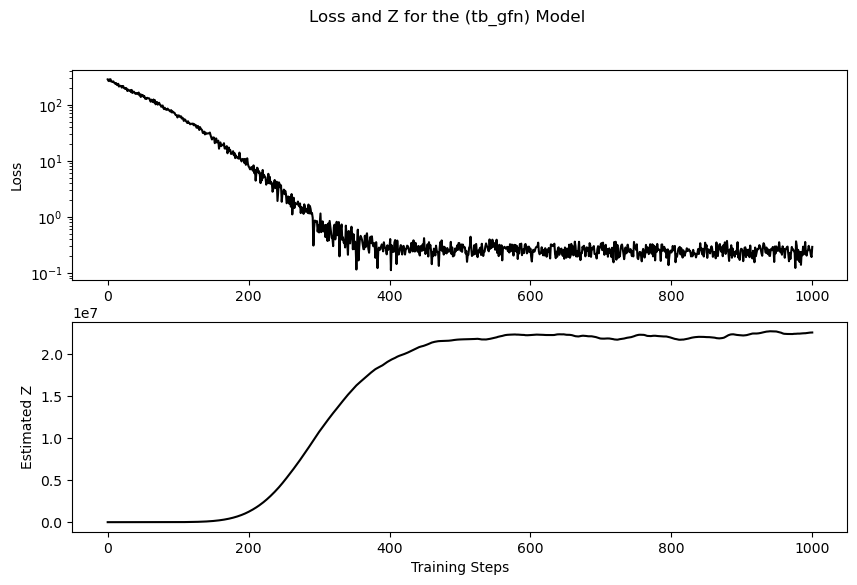

The final Z (partition function) estimate is 22593055.82


In [19]:
title = "Loss and Z for the ({}) Model".format(args.method)
plot_loss_curve(all_losses, logZs=logZs, title=title)
print("The final Z (partition function) estimate is {:.2f}".format(np.exp(logZs[-1])))

# print(agent.state_counts)
# print(agent.state_returns)

In [20]:
prod = np.prod([float(r) for r in ['0.475', '1.550', '0.535', '0.413', '0.499', '0.499', '0.413', '0.663', '0.440', '0.535', '0.413', '0.475', '0.440', '0.663', '1.550', '0.475', '0.440', '0.535', '1.316', '1.550']])
print(prod)


5.282378190817391e-05


In [21]:
prod

5.282378190817391e-05